In [1]:
import glob,os
import sys
import math                   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tifffile import imread, imwrite, TiffFile
import pyclesperanto_prototype as cle
import scipy 
import scipy.signal as sig
import skimage.io as skio
from skimage.morphology import disk, binary_erosion, binary_dilation, binary_opening, binary_closing, remove_small_objects
from skimage.restoration import rolling_ball 
from skimage.measure import label
from skimage.filters import gaussian
import imageio
import moviepy.editor as mp
import cv2

#################################################
#############   USER INPUTS   ###################
#################################################

num_lines = 180 #how many line scans per frame
line_length = 150 #choose you line length
num = 150 #number of data points per line
image_path = '/Users/domchom/Documents/GitHub/Dom_python_scripts/wound_close_quant/MAX_Exp049_dTom-rGBD_GFP-wGBD_control_cellA-001_raw.tif' #path to movie of interest

#import the image
img = imread(image_path)

# standardize image dimensions
with TiffFile(image_path) as tif_file:
    metadata = tif_file.imagej_metadata
num_channels = metadata.get('channels', 1)
num_slices = metadata.get('slices', 1)
num_frames = metadata.get('frames', 1)
img = img.reshape(num_frames, 
                  num_slices, 
                  num_channels, 
                  img.shape[-2], 
                  img.shape[-1])

#finding the center of of the ring by masking each frame to display the ring, and then finding the center of mass of the ring. Then average each suitable (has a ring) frame.
centroid_x = []
centroid_y = []

for n in range(num_channels):
    for i in range(num_frames):
        mask = img[i][0][n] > np.mean(img[i][0][n])*2 #masked the image
        blurred = gaussian(mask, 5) #blurring that first mask
        circle = blurred > np.mean(blurred)*5 #masking the mask
        circle_eroded4 = binary_erosion(circle, disk(1)) #to help with binary erosion
        circle_only = remove_small_objects(circle_eroded4, min_size=6000) #filtering out the smaller regions, like membrane folds
        labeled_circles = label(circle_only, connectivity=2) #for labelling the structures
        if np.mean(labeled_circles) == 0:
            pass
        else:
            #print(f'frame {i} contains a circle')
            #cle.imshow(labeled_circles, labels = True)
            cen = scipy.ndimage.center_of_mass(circle_only)
            centroid_x.append(cen[0])
            centroid_y.append(cen[1])

centroid = [sum(centroid_x) / len(centroid_x),  sum(centroid_y) / len(centroid_y)]

#calculating all the lines needed for the linescans
line_coords = [] #list to fill with lines
degree_diff = 360/num_lines #calc difference in degrees betweeen the lines
radian_diff = math.radians(degree_diff)

def create_line(n, quadrant):
    x0, y0 = centroid[0], centroid[1] 
    x_length = (line_length * math.sin(n))
    x1 = centroid[0] + x_length 
    y_length = math.sqrt((line_length**2) - (x_length**2))
    if quadrant == 'BR' or quadrant == 'BL':
        y1 = centroid[1] + y_length
    else:
        y1 = centroid[1] - y_length
    x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
    coords = [x,y]
    line_coords.append(coords)

m = 0
i = 0
for line in range(num_lines):
    if m == 0: #first line
        create_line(i, 'BR')
        i += radian_diff
        m += 1
    else:
        if m < num_lines / 4:
            create_line(i, 'BR')
        elif m < num_lines / 2:
            create_line(i, 'TR')
        elif m < ((num_lines / 2) + (num_lines / 4)):
            create_line(i + radian_diff, 'BL') 
        else:
            create_line(i + radian_diff, 'TL') 
        i += radian_diff
        m += 1

print(f'CENTROID: {centroid}')

#perform the line scans

frames_list = [] # store all the signals for every frame

c = 0 #which channel to start with
for n in range(num_channels): #iterate over the channels
    f=0 #which frame to start with
    for frame in range(num_frames): #iterate over the frames
        signals_list = [] #lost to store the signal for each line for the frame
        print(f'calculating channel {c+1}, frame {f+1}')
        for line in line_coords: #create each line for each frame
            x, y = line[0], line[1]
            x0, x1 = x[0], x[-1]
            y0, y1= y[0], y[-1]

            # Extract the values along the line, using cubic interpolation
            signal = scipy.ndimage.map_coordinates(img[f][0][c], np.vstack((x,y)))
            signals_list.append(signal)

            '''#Plot
            fig, axes = plt.subplots(nrows=2)
            axes[0].imshow(img[f][0][c])
            axes[0].plot([x0, x1], [y0, y1], 'r-')
            axes[0].axis('image')

            axes[1].plot(signal)

            plt.show()'''
        frames_list.append(signals_list)
        f += 1
    c += 1

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


CENTROID: [265.18870195963757, 247.92055125010162]
calculating channel 1, frame 1
calculating channel 1, frame 2
calculating channel 1, frame 3
calculating channel 1, frame 4
calculating channel 1, frame 5
calculating channel 1, frame 6
calculating channel 1, frame 7
calculating channel 1, frame 8
calculating channel 1, frame 9
calculating channel 1, frame 10
calculating channel 1, frame 11
calculating channel 1, frame 12
calculating channel 1, frame 13
calculating channel 1, frame 14
calculating channel 1, frame 15
calculating channel 1, frame 16
calculating channel 1, frame 17
calculating channel 1, frame 18
calculating channel 1, frame 19
calculating channel 1, frame 20
calculating channel 1, frame 21
calculating channel 1, frame 22
calculating channel 1, frame 23
calculating channel 1, frame 24
calculating channel 1, frame 25
calculating channel 1, frame 26
calculating channel 1, frame 27
calculating channel 1, frame 28
calculating channel 1, frame 29
calculating channel 1, frame 3

In [113]:
#averaging every frame to create just one line per frame for each channel

frames_array = np.array(frames_list)

channel1_raw_values, channel2_raw_values = np.array_split(frames_array, 2)

mean_values_Ch1 = []

i = 0
for frame in channel1_raw_values:
    n = 0
    pixel_avg_per_frame = []
    for x in range(num):
        pixel_avg_per_frame.append(frame[:,n].mean())
        n+=1
    mean_values_Ch1.append(pixel_avg_per_frame)
    i+=1

raw_mean_values_Ch1 = np.array(mean_values_Ch1)

mean_values_Ch2 = []

i = 0
for frame in channel2_raw_values:
    n = 0
    pixel_avg_per_frame = []
    for x in range(num):
        pixel_avg_per_frame.append(frame[:,n].mean())
        n+=1
    mean_values_Ch2.append(pixel_avg_per_frame)
    i+=1

raw_mean_values_Ch2 = np.array(mean_values_Ch2)

mean_values_both_ch = np.stack((raw_mean_values_Ch1, raw_mean_values_Ch2))

In [116]:
#normalize the data

norm_to_max_mean_values_Ch1 = []

for signal in raw_mean_values_Ch1:
    #signal = sig.savgol_filter(signal, window_length = 30, polyorder = 2) #to smooth the line
    norm_values = []
    for pixel in signal:
        pixel_norm = (pixel/np.max(signal))
        norm_values.append(pixel_norm)
    norm_to_max_mean_values_Ch1.append(norm_values)


norm_to_max_mean_values_Ch2 = []

for signal in raw_mean_values_Ch2:
    #signal = sig.savgol_filter(signal, window_length = 30, polyorder = 2) #to smooth the line
    norm_values = []
    for pixel in signal:
        pixel_norm = (pixel/np.max(signal))
        norm_values.append(pixel_norm)
    norm_to_max_mean_values_Ch2.append(norm_values)

#normalize the over data background signal

mean_values_Ch1_norm_bg = []

for signal in raw_mean_values_Ch1:
    signal = sig.savgol_filter(signal, window_length = 30, polyorder = 2) #to smooth the line
    norm_values = []
    for pixel in signal:
        pixel_norm = (pixel - np.min(raw_mean_values_Ch2)) * ( (1 - 0) / (np.max(raw_mean_values_Ch2) - np.min(raw_mean_values_Ch2))) #np.mean(img[i][0][0][:10][:10])) #normalize to average pixel value top left 10 pixels of the frame 
        norm_values.append(pixel_norm)
    mean_values_Ch1_norm_bg.append(norm_values)


mean_values_Ch2_norm_bg = []

for signal in raw_mean_values_Ch2:
    signal = sig.savgol_filter(signal, window_length = 30, polyorder = 2) #to smooth the line
    norm_values = []
    for pixel in signal:
        pixel_norm = (pixel - np.min(raw_mean_values_Ch2)) * ( (1 - 0) / (np.max(raw_mean_values_Ch2) - np.min(raw_mean_values_Ch2))) #(pixel / np.mean(img[i][0][1][:10][:10])) #normalize to average pixel value top left 10 pixels of the frame 
        norm_values.append(pixel_norm)
    mean_values_Ch2_norm_bg.append(norm_values)

# to smooth raw data

mean_values_Ch1_smooth = []

for signal in raw_mean_values_Ch1:
    signal = sig.savgol_filter(signal, window_length = 11, polyorder = 2) #to smooth the line
    mean_values_Ch1_smooth.append(signal)

mean_values_Ch2_smooth = []

for signal in raw_mean_values_Ch2:
    signal = sig.savgol_filter(signal, window_length = 11, polyorder = 2) #to smooth the line
    mean_values_Ch2_smooth.append(signal)

In [115]:
#find peaks - will treat each frame like a box

# make empty arrays to fill with peak measurements for each channel
peak_widths = np.zeros(shape=(num_channels, num_frames))
peak_maxs = np.zeros(shape=(num_channels, num_frames))
peak_mins = np.zeros(shape=(num_channels, num_frames))

# make a dictionary to store the arrays and measurments generated by this function so they don't have to be re-calculated later
ind_peak_props = {}

for channel in range(num_channels):
    for frame_num in range(num_frames):

        signal = sig.savgol_filter(mean_values_both_ch[channel][frame_num], window_length = 11, polyorder = 2)
        peaks, _ = sig.find_peaks(signal, prominence=(np.max(signal)-np.min(signal))*0.65) #<--- edit last number to change the threshold

        # if peaks detected, calculate properties and return property averages. Otherwise return nans
        if len(peaks) > 0:
            proms, _, _ = sig.peak_prominences(signal, peaks)
            widths, heights, leftIndex, rightIndex = sig.peak_widths(signal, peaks, rel_height=0.5)
            mean_width = np.mean(widths, axis=0)
            mean_max = np.mean(signal[peaks], axis = 0)
            mean_min = np.mean(signal[peaks]-proms, axis = 0)
            peak_widths[channel, frame_num] = mean_width
            peak_maxs[channel, frame_num] = mean_max
            peak_mins[channel, frame_num] = mean_min

            # store the smoothed signal, peak locations, maxs, mins, and widths for each box in each channel
            ind_peak_props[f'Ch {channel} Box {frame_num}'] = {'smoothed': signal, 
                                                    'peaks': peaks,
                                                    'proms': proms, 
                                                    'heights': heights, 
                                                    'leftIndex': leftIndex, 
                                                    'rightIndex': rightIndex}
                
        else:
            peak_widths[channel, frame_num] = np.nan
            peak_maxs[channel, frame_num] = np.nan
            peak_mins[channel, frame_num] = np.nan

            # store the smoothed signal, peak locations, maxs, mins, and widths for each box in each channel
            # DC: might not acutally need this, as the code works fine without it (221222). Just putting for safety.
            ind_peak_props[f'Ch {channel} Frame {frame_num}'] = {'smoothed': np.nan, 
                                                    'peaks': np.nan,
                                                    'proms': np.nan, 
                                                    'heights': np.nan, 
                                                    'leftIndex': np.nan, 
                                                    'rightIndex': np.nan}

peak_amps = peak_maxs - peak_mins
peak_rel_amps = peak_amps / peak_mins


In [135]:
# make a list of unique channel combinations to calculate CCF for
channels = list(range(num_channels))
channel_combos = []
for i in range(num_channels):
    for j in channels[i+1:]:
        channel_combos.append([channels[i],j])
num_combos = len(channel_combos)

# make empty arrays to populate with 1) period measurements and 2) acf curves   
shifts = np.zeros(shape=(num_combos, num_frames))
ccfs = np.zeros(shape=(num_combos, num_frames, line_length*2-11))

for combo_number, combo in enumerate(channel_combos):
    for frame_num in range(num_frames):
    
        # calculate full cross-correlation
        signal1 = mean_values_both_ch[0][frame_num][5:]
        signal2 = mean_values_both_ch[1][frame_num][5:]

        peaks1, _ = sig.find_peaks(signal1, prominence=(np.max(signal)-np.min(signal))*0.15) #<--- edit last number to change the threshold
        peaks2, _ = sig.find_peaks(signal2, prominence=(np.max(signal)-np.min(signal))*0.15) #<--- edit last number to change the threshold

        if len(peaks1) > 0 and len(peaks2) > 0:
            corr_signal1 = signal1 - signal1.mean()
            corr_signal2 = signal2 - signal2.mean()
            cc_curve = np.correlate(corr_signal1, corr_signal2, mode='full')
            # normalize the curve
            cc_curve = sig.savgol_filter(cc_curve, window_length = 30, polyorder = 2)

            cc_curve = cc_curve / (num_frames * signal1.std() * signal2.std())

            peaks, _ = sig.find_peaks(cc_curve, prominence=0.01)
            
            # absolute difference between each peak and zero
            peaks_abs = abs(peaks - cc_curve.shape[0]//2)
            # if peaks were identified, pick the one closest to the center
            if len(peaks) > 1:
                delay = np.argmin(peaks_abs[np.nonzero(peaks_abs)])
                delayIndex = peaks[delay]
                delay_frames = delayIndex - cc_curve.shape[0]//2
            # otherwise, return nans for both period and autocorrelation curve
            else:
                delay_frames = np.nan
                cc_curve = np.full((line_length*2-11), np.nan)
        else:
            delay_frames = np.nan
            cc_curve = np.full((line_length*2-11), np.nan)
        shifts[combo_number, frame_num] = delay_frames
        ccfs[combo_number, frame_num] = cc_curve

print(shifts)

[[ nan  nan  nan  nan  nan  nan  nan  nan  nan  -6. -11. -12. -13. -14.
  -16. -16. -18. -19. -20. -21. -22. -22. -23. -23. -23. -22. -22. -21.
  -20. -20. -19. -19. -19. -18. -18. -17. -16. -16. -16. -15. -15. -14.
  -14. -13. -13. -13. -12. -12. -12. -12. -12.]]


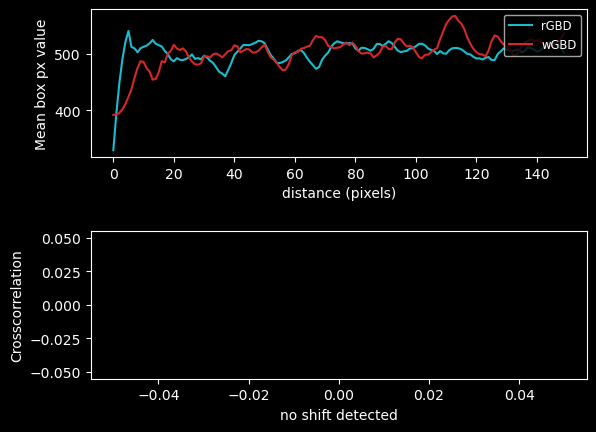

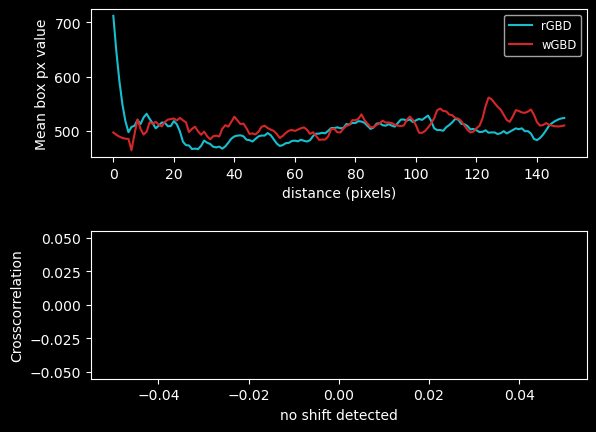

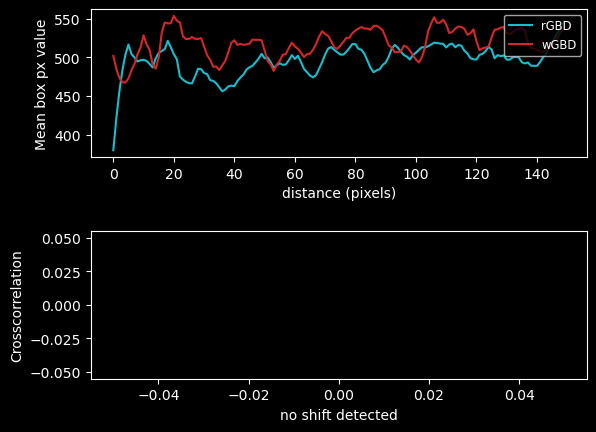

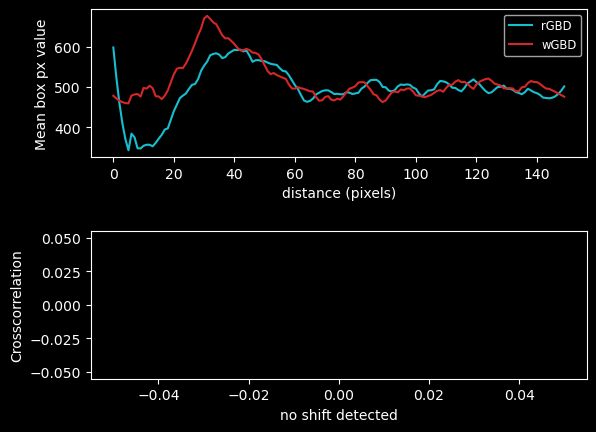

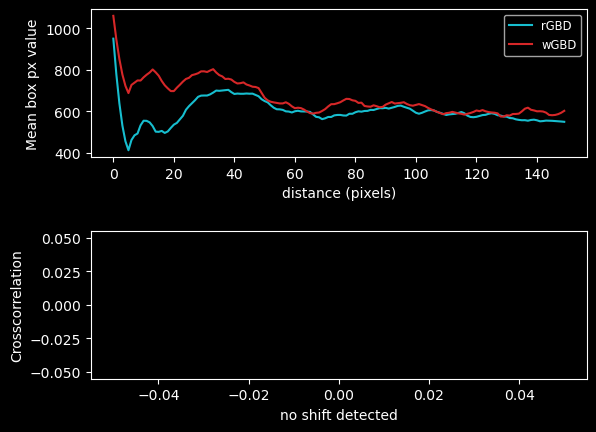

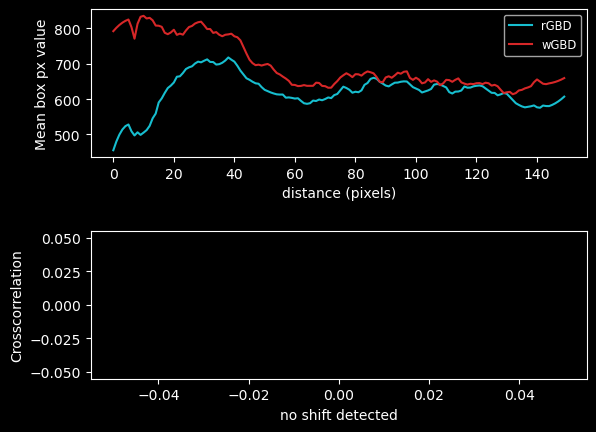

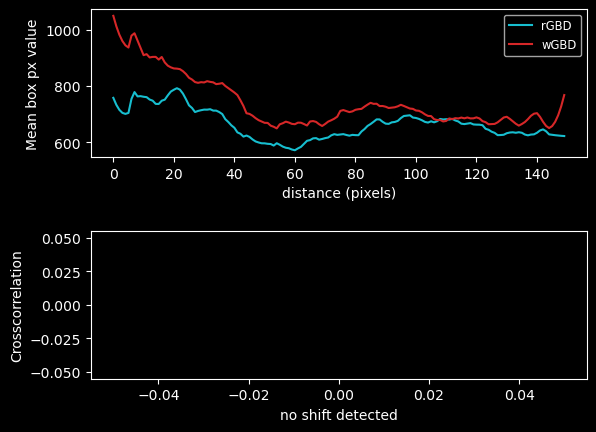

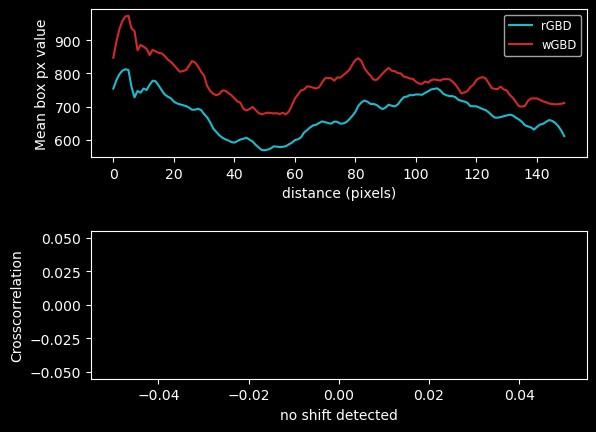

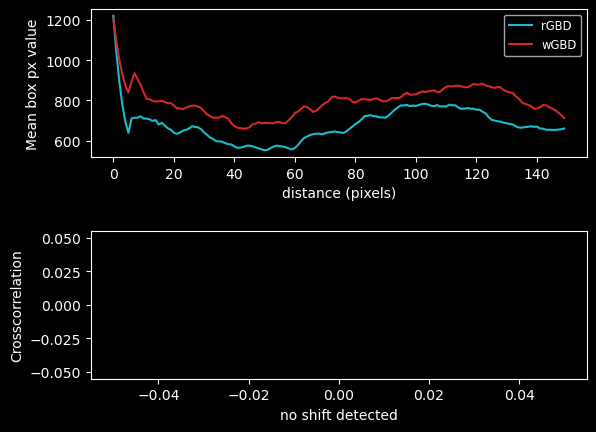

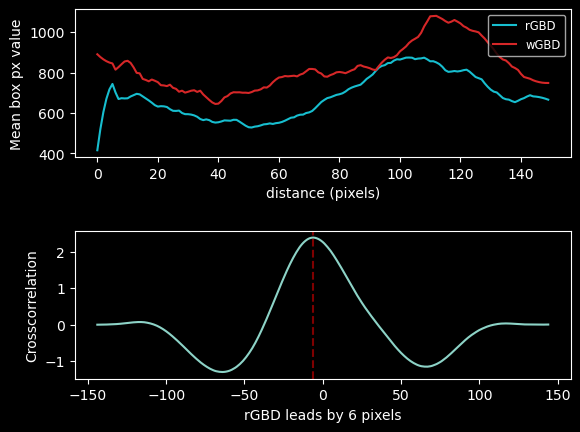

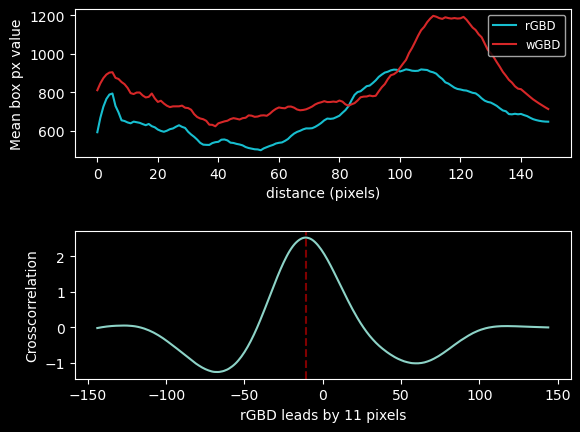

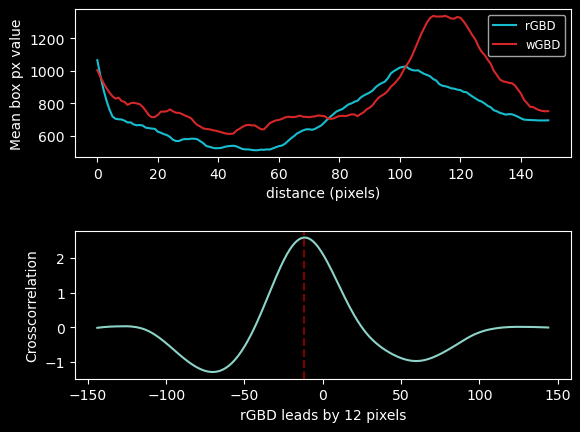

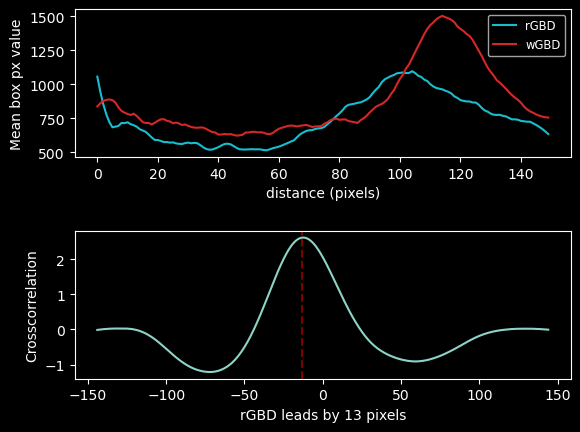

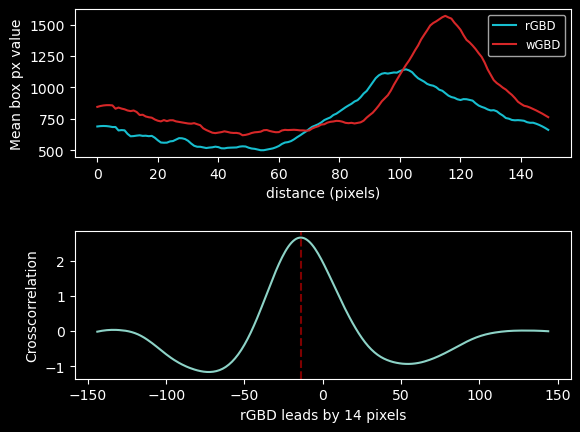

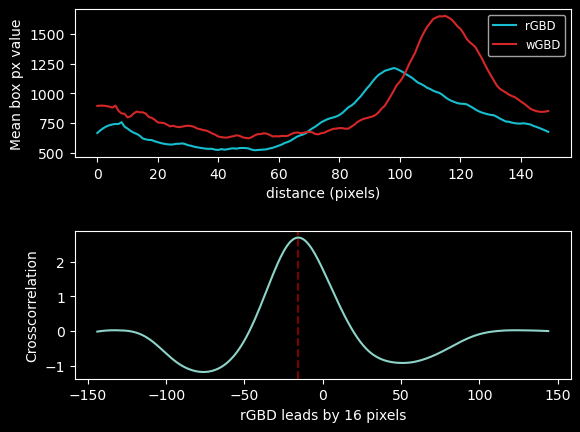

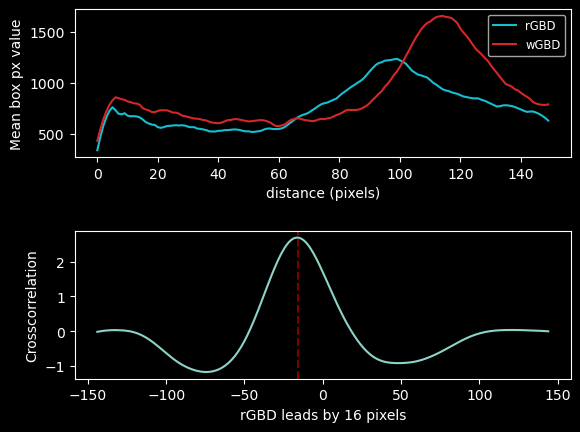

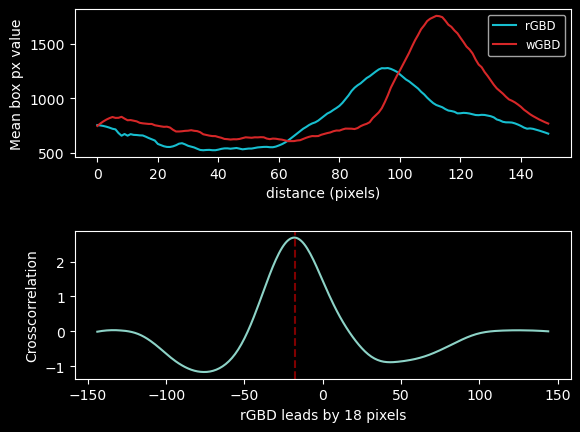

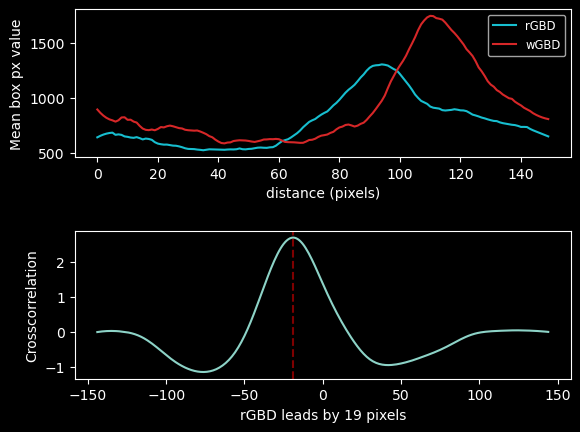

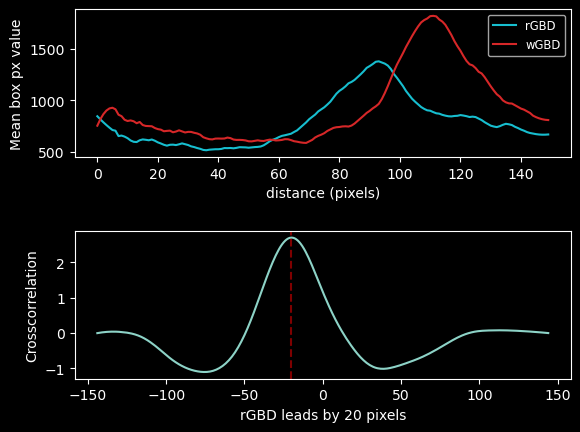

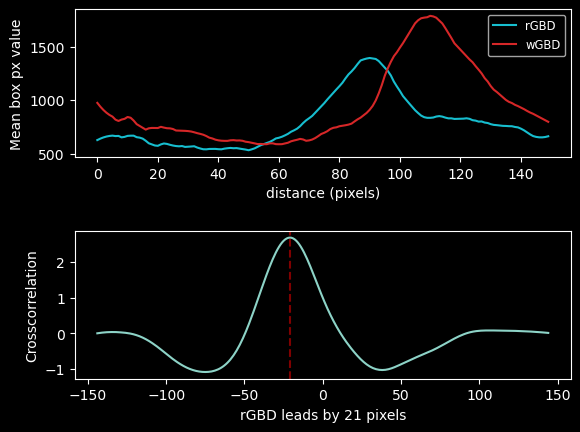

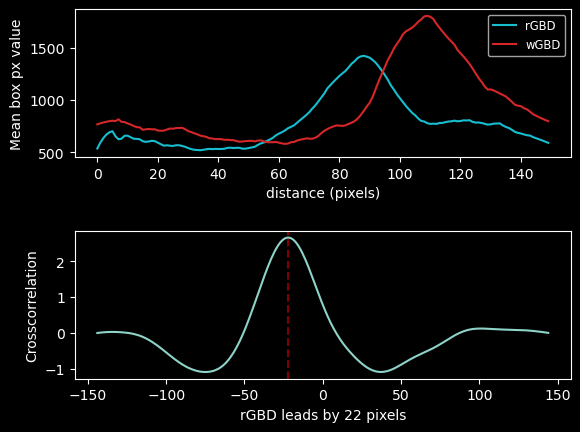

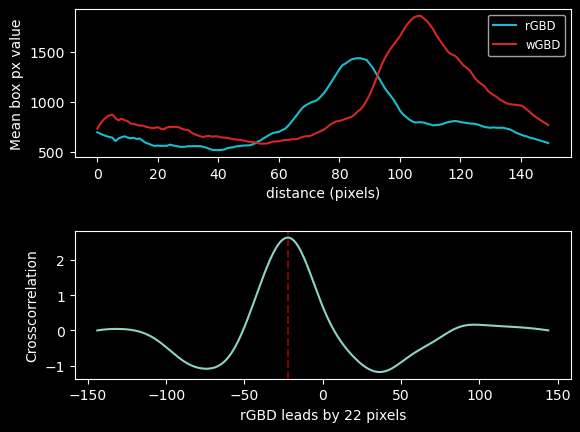

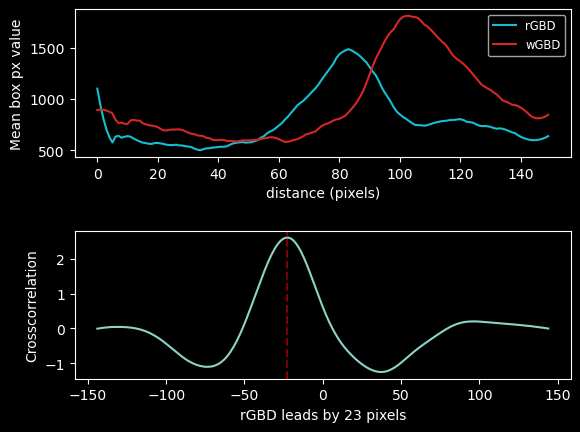

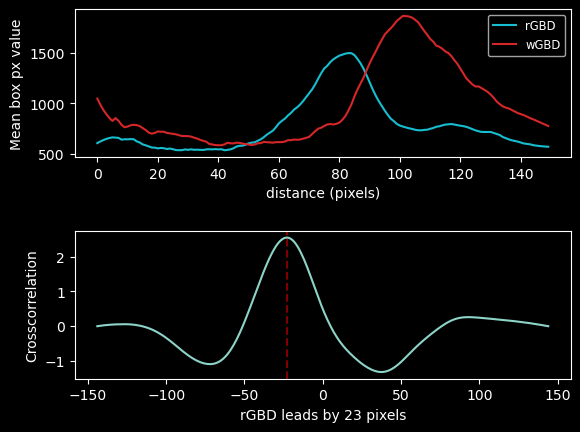

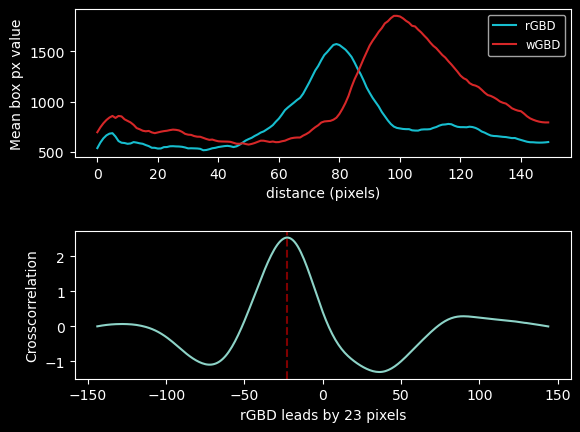

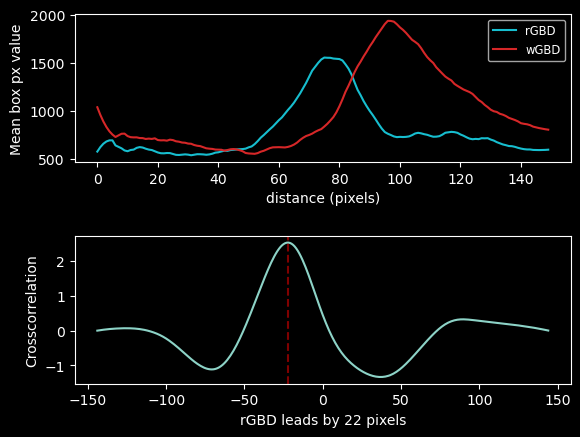

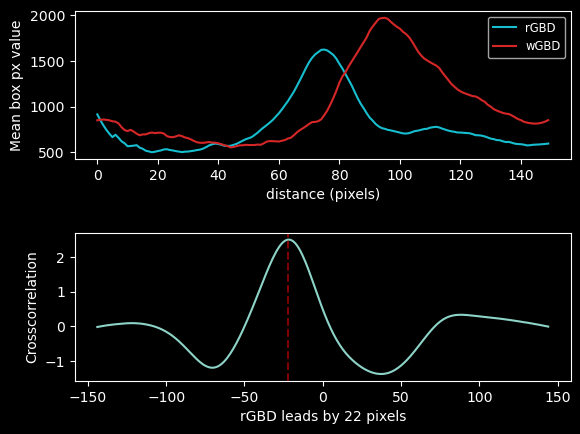

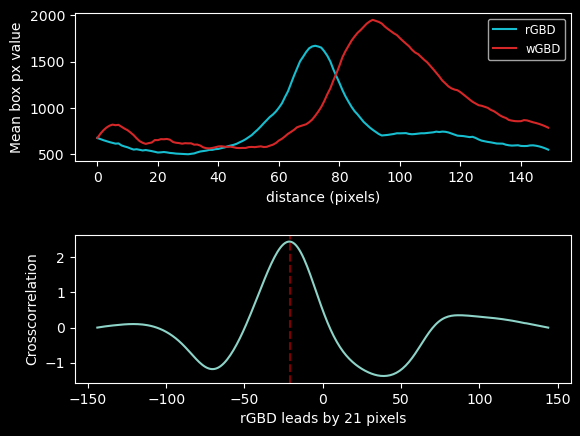

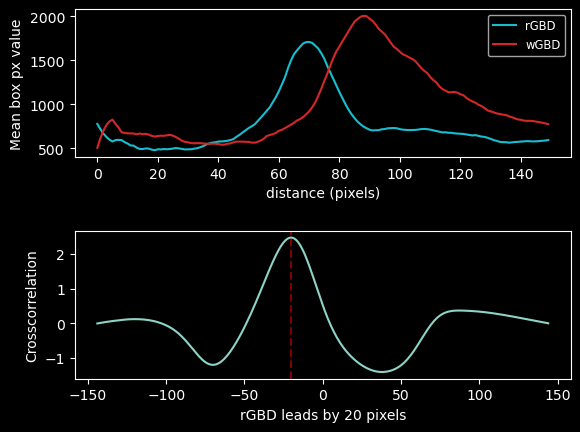

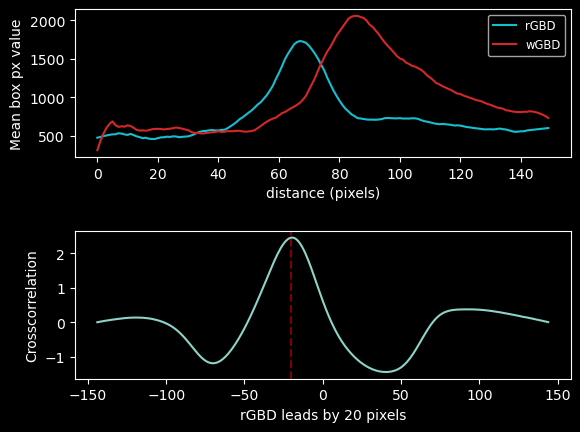

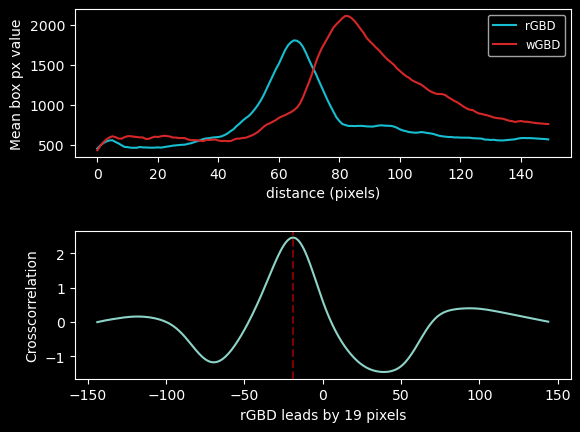

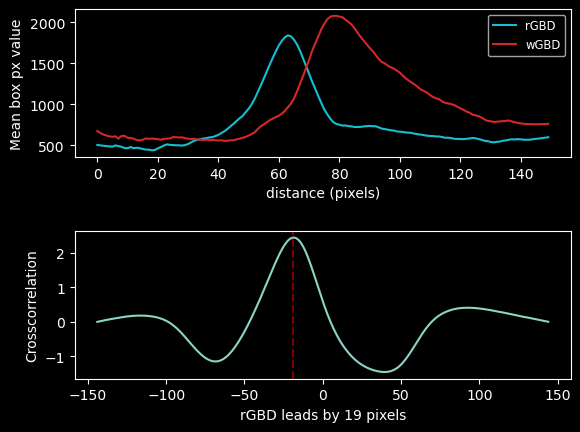

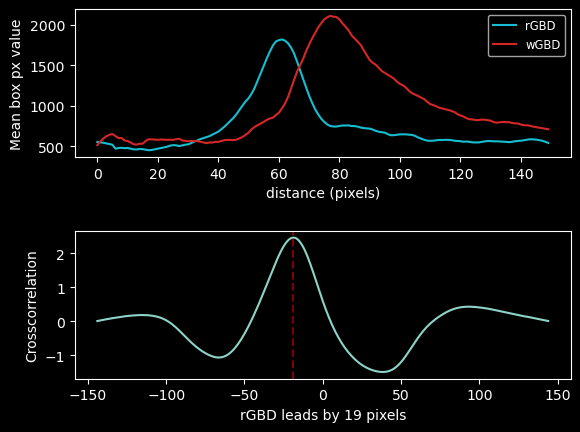

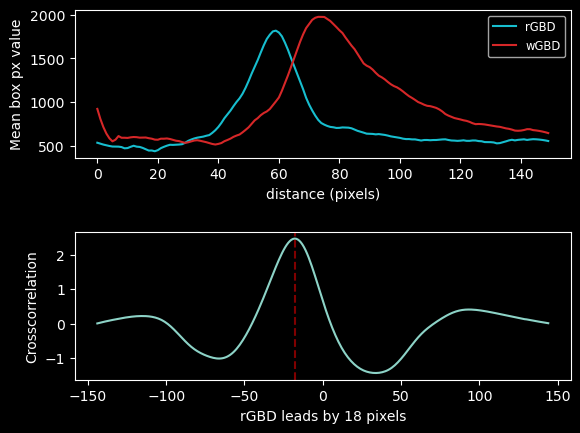

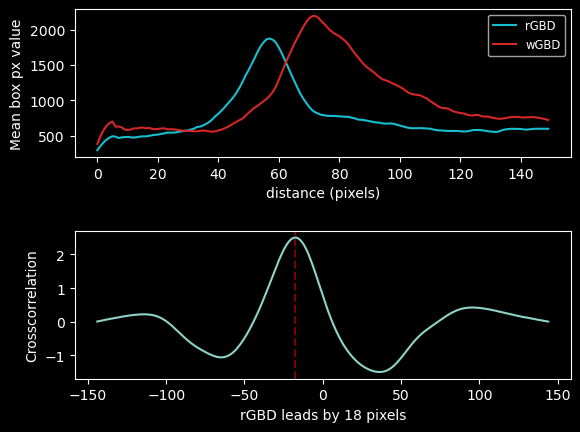

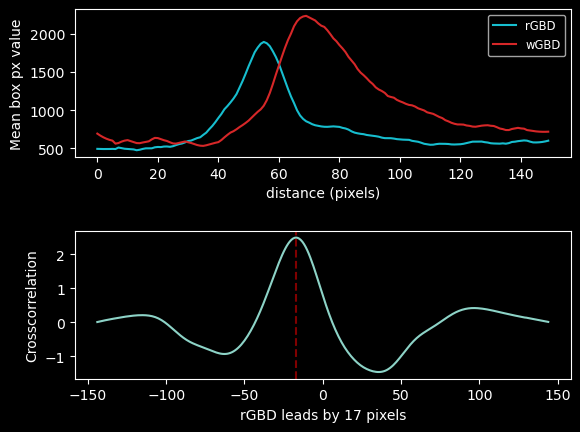

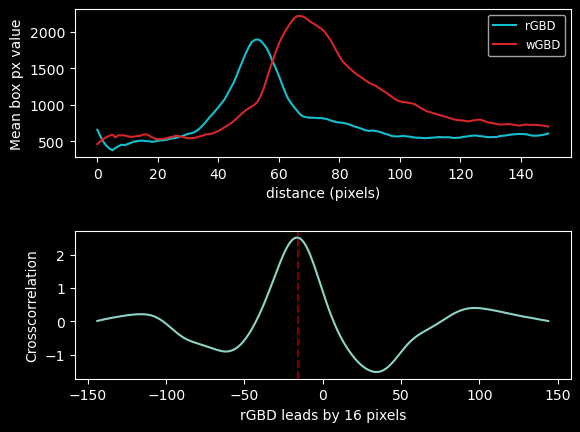

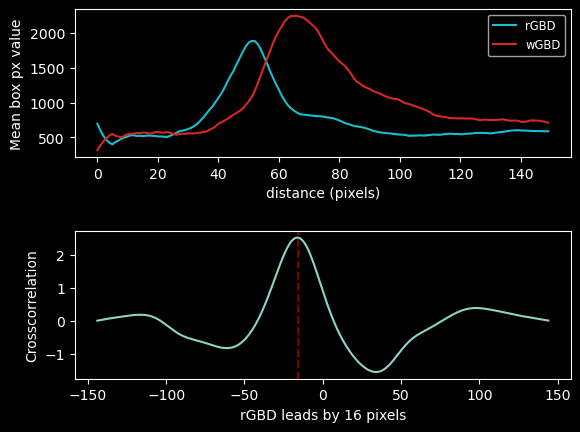

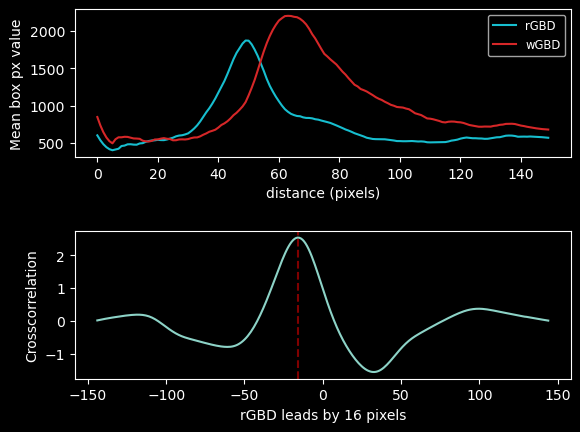

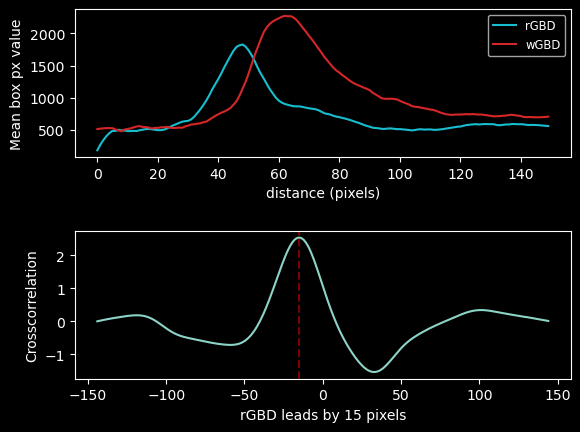

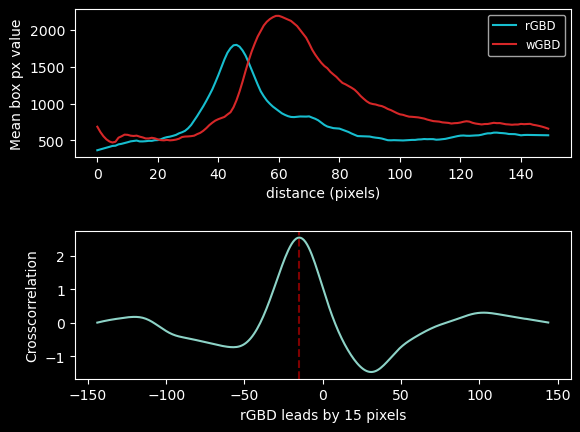

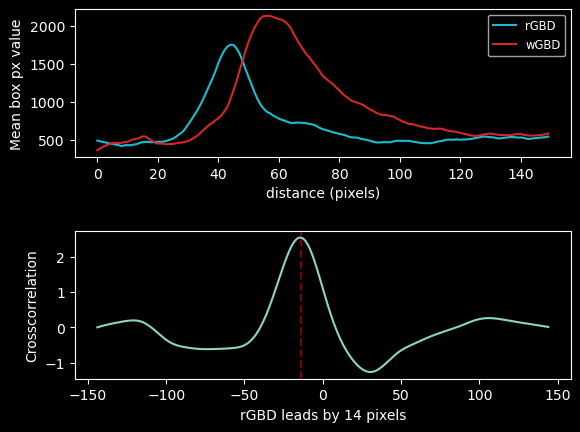

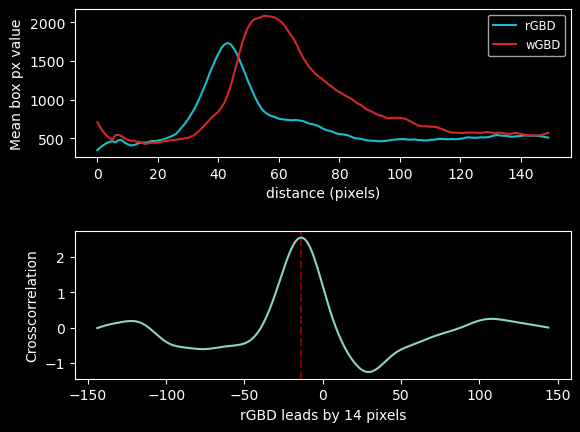

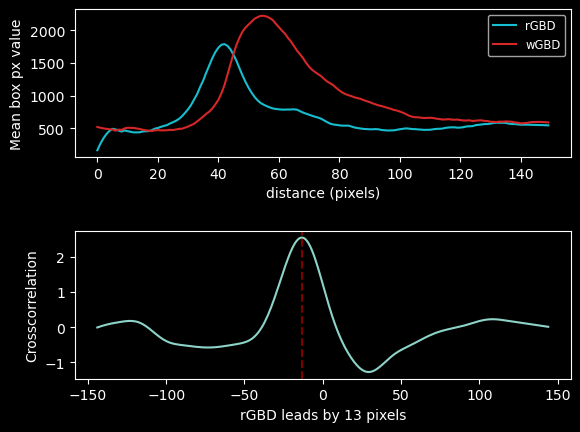

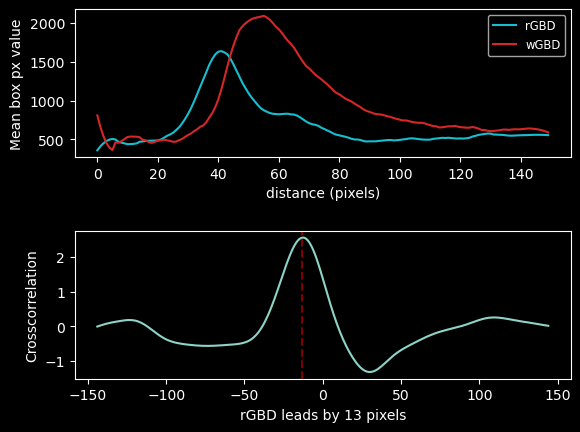

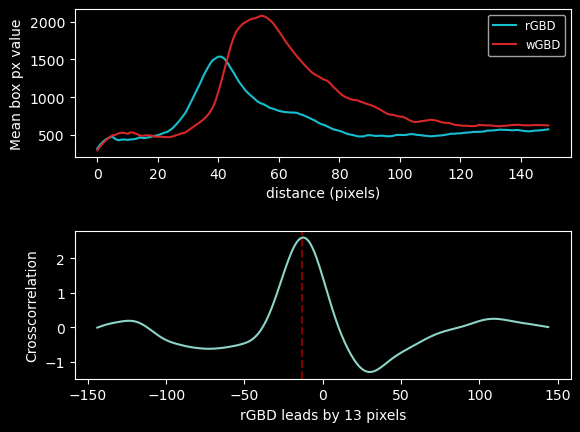

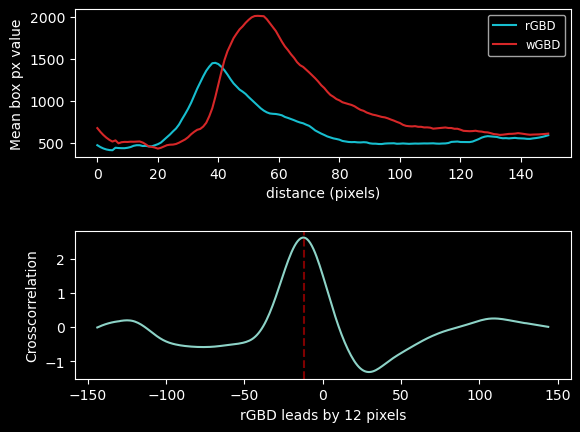

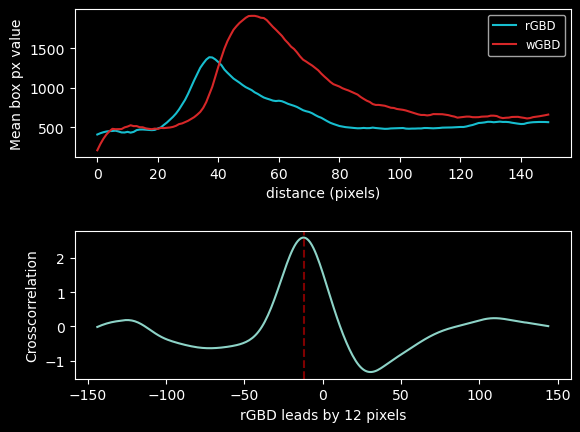

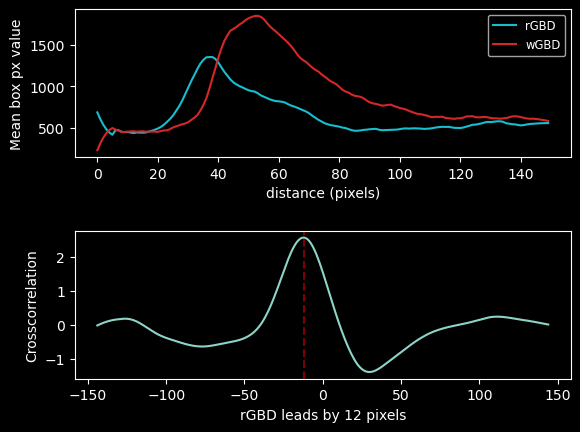

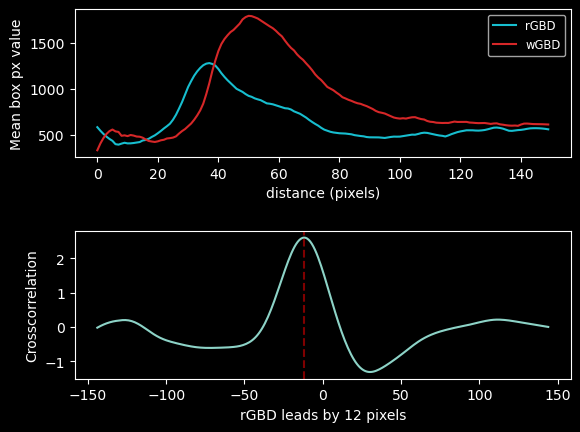

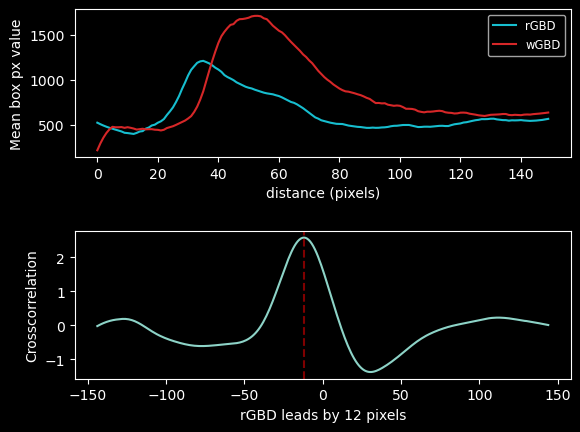

In [136]:
def return_figure(ch1: np.ndarray, ch2: np.ndarray, ccf_curve: np.ndarray, ch1_name: str, ch2_name: str, shift: int):
    '''
    Space saving function to generate individual plots with variable input. returns a figure object.
    '''
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(ch1, color = 'tab:cyan', label = ch1_name)
    ax1.plot(ch2, color = 'tab:red', label = ch2_name)
    ax1.set_xlabel('distance (pixels)')
    ax1.set_ylabel('Mean box px value')
    ax1.legend(loc='upper right', fontsize = 'small', ncol = 1)
    ax2.plot(np.arange(-line_length + 6, line_length - 5), ccf_curve)
    ax2.set_ylabel('Crosscorrelation')
    
    if not shift == np.nan:
        color = 'red'
        ax2.axvline(x = shift, alpha = 0.5, c = color, linestyle = '--')
        if shift < 1:
            ax2.set_xlabel(f'{ch1_name} leads by {int(abs(shift))} pixels')
        elif shift > 1:
            ax2.set_xlabel(f'{ch2_name} leads by {int(abs(shift))} pixels')
        else:
            ax2.set_xlabel('no shift detected')
    else:
        ax2.set_xlabel(f'No peaks identified')
    
    fig.subplots_adjust(hspace=0.5)
    plt.show(fig)
    return(fig)

def normalize(signal: np.ndarray):
    '''
    Normalize between 0 and 1
    '''
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

i=0
for frame in range(num_frames):
    return_figure(mean_values_Ch1_smooth[frame], mean_values_Ch2_smooth[frame], ccfs[0][i], "rGBD", "wGBD", shifts[0][i])
    i+=1

In [40]:
#saving the graphs as movies

def graph_line_scans(mean_values_Ch1, mean_values_Ch2, filename):
    i = 0
    for signal in mean_values_Ch1:
        max_ch1 = np.max(mean_values_Ch1)
        max_ch2 = np.max(mean_values_Ch2)

        if max_ch1 > max_ch2:
            y_max = max_ch1
        else:
            y_max = max_ch2

        #Plot
        plt.style.use('dark_background')
        plt.figure(figsize=(8,5))
        ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
        ax2 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
        ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
        plt.tight_layout()

        ax1.plot(signal, color='cyan')
        ax1.plot(mean_values_Ch2[i], color='red')
        ax1.set_ylim([0, y_max])

        #ax2.imshow(img[i][0][0])
        #ax3.imshow(img[i][0][1], cmap=plt.cm.Reds_r)
        plt.title(f'frame {i}')

        plt.savefig(f'line-{i}.png')
        #plt.show()
        plt.close()
        i+=1

    with imageio.get_writer(f'{filename}.gif', mode='i') as writer:
        for i in range(len(mean_values_Ch1)):
            image = imageio.imread(f'line-{i}.png')
            writer.append_data(image)

    clip = mp.VideoFileClip(f"{filename}.gif")
    clip.write_videofile(f"{filename}.mp4")

    for filename in glob.glob("/Users/domchom/Documents/GitHub/Dom_python_scripts/wound_close_quant/line*"):
        os.remove(filename) 
    for item in os.listdir('/Users/domchom/Documents/GitHub/Dom_python_scripts/wound_close_quant/'):
        if item.endswith(".gif"):
            os.remove(os.path.join('/Users/domchom/Documents/GitHub/Dom_python_scripts/wound_close_quant/', item))

#graph_line_scans(raw_mean_values_Ch1, raw_mean_values_Ch2, 'raw')

#graph_line_scans(norm_to_max_mean_values_Ch1, norm_to_max_mean_values_Ch2, 'norm to max pixel value')

graph_line_scans(mean_values_Ch1_norm_bg, mean_values_Ch2_norm_bg, 'norm to bg pixel value')

graph_line_scans(mean_values_Ch1_smooth, mean_values_Ch2_smooth, 'smoothe raw')




Moviepy - Building video norm to bg pixel value.mp4.
Moviepy - Writing video norm to bg pixel value.mp4



Moviepy - Done !
Moviepy - video ready norm to bg pixel value.mp4


Moviepy - Building video smoothe raw.mp4.
Moviepy - Writing video smoothe raw.mp4



Moviepy - Done !
Moviepy - video ready smoothe raw.mp4
